# Test VRP Service 
- This notebook allows experimentation and testing of the VRP Service calls

<span style="color:red; font-weight:bold">Note:</span> Remember to Restart the Notebook **if you have changed code**.<br>The notebook does not auto reload.

In [1]:
# System level imports
import sys
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
TEST_DEV_PRJ_PATH = os.environ.get("TEST_DEV_PRJ_PATH")

# ##### SET SYS PATH TO WHERE THE CODE IS. #####
# Note: Putting our code first in the sys path will make sure it gets picked up
sys.path.insert(0, f"{TEST_DEV_PRJ_PATH}/backend/src")
print(sys.path)

['/Users/dan/Code/Python/Ken/route-optimize/backend/src', '/Users/dan/miniforge3/envs/py3.13/lib/python313.zip', '/Users/dan/miniforge3/envs/py3.13/lib/python3.13', '/Users/dan/miniforge3/envs/py3.13/lib/python3.13/lib-dynload', '', '/Users/dan/Code/Python/Ken/route-optimize/.venv/lib/python3.13/site-packages']


In [2]:
# Get the services that we will use
import pandas as pd
from wulfs_routing_api.services.order_services import OrderService
from wulfs_routing_api.models.orders.supabase_order import OrderModel
from wulfs_routing_api.models.customers.supabase_customer import SupabaseCustomer
from wulfs_routing_api.services.customer_service import CustomerService
from wulfs_routing_api.services.vrp_service import VRPService

customer_service = CustomerService(SupabaseCustomer())
order_service = OrderService(OrderModel())
vrp_service = VRPService()

✅ Supabase client initialized.


In [3]:
# Things we need to call the solver
number_vehicles=4
depot_coordinates=(42.34902,-71.03118)
orders_df = pd.read_csv("../../data/orders_w_customers.csv")
orders_df.head()

,customer_name_order,order_id,notes,name_key,customer_id,customer_name,address,city,state,zip,location,lon,lat
0,Bar Volpe,NaN,NaN,bar volpe,3.0,Bar Volpe,170 W Broadway,Boston,MA,2127,0101000020E6100000A33F34F364C351C0D354AA9F922B...,-71.053037,42.340412
1,Fox & The Knife,NaN,NaN,fox the knife,4.0,Fox & The Knife,28 West Broadway,South Boston,MA,2127,0101000020E61000009EAB521F6DC351C0C2120F289B2B...,-71.053535,42.340672
2,Dryft Revere,NaN,NaN,dryft revere,7.0,Dryft Revere,500 Ocean Ave,Revere,MA,2151,0101000020E6100000F414DE8A69BF51C065D9DD4D0135...,-70.990817,42.414102
3,Bar Mezzana,NaN,NaN,bar mezzana,13.0,Bar Mezzana,360 Harrison Avenue,Boston,MA,2118,0101000020E6100000FD38509610C451C039D0436D1B2C...,-71.063512,42.344587
4,Black Lamb,NaN,NaN,black lamb,14.0,Black Lamb,571 Tremont Street,Boston,MA,2118,0101000020E610000023A0C211A4C451C05CE7DF2EFB2B...,-71.072514,42.343603


In [4]:
# We crash and burn on calling the solver **solve_vrp**
# Lets test the intermediate function calls

haversine_distance = vrp_service._haversine_distance
# 1️⃣ Same point (distance should be 0)
assert abs(haversine_distance(0, 0, 0, 0)) < 1e-6

# 2️⃣ Approx distance between:
# New York City (40.7128, -74.0060) and London (51.5074, -0.1278)
dist_nyc_london = haversine_distance(40.7128, -74.0060, 51.5074, -0.1278)
print("NYC → London:", dist_nyc_london/1000, "km")
assert 5500*1000 < dist_nyc_london < 5650*1000  # expected ≈ 5570 km

# 3️⃣ San Francisco (37.7749, -122.4194) and Los Angeles (34.0522, -118.2437)
dist_sf_la = haversine_distance(37.7749, -122.4194, 34.0522, -118.2437)
print("SF → LA:", dist_sf_la/1000, "km")
assert 540*1000 < dist_sf_la < 570*1000  # expected ≈ 559 km

# 4️⃣ Paris (48.8566, 2.3522) and Berlin (52.5200, 13.4050)
dist_paris_berlin = haversine_distance(48.8566, 2.3522, 52.5200, 13.4050)
print("Paris → Berlin:", dist_paris_berlin/1000, "km")
assert 875*1000 < dist_paris_berlin < 895*1000  # expected ≈ 878 km

print("✅ All Haversine tests passed!")

NYC → London: 5570.222 km
SF → LA: 559.12 km
Paris → Berlin: 877.463 km
✅ All Haversine tests passed!


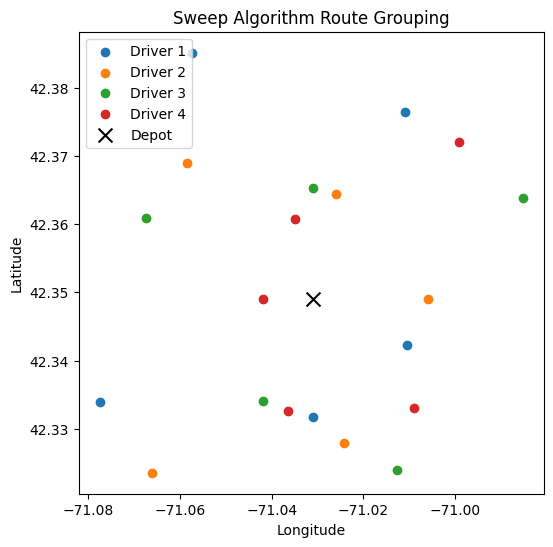

In [ ]:
# Plot the sweep function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

split_sweep = vrp_service._split_sweep
# --- Synthetic data ---
np.random.seed(42)
n_points = 20
hq_lat, hq_lon = 42.349, -71.031  # Boston HQ (example)
angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
radii = np.random.uniform(0.01, 0.05, n_points)

# Create points in a rough circle
lats = hq_lat + radii * np.sin(angles)
lons = hq_lon + radii * np.cos(angles)
df = pd.DataFrame({'lat': lats, 'lon': lons})

# --- Use the sweep split function ---
k = 4
labels = split_sweep(df, k, (hq_lat, hq_lon))

# --- Plot results ---
plt.figure(figsize=(6,6))
for i in range(k):
    group = df[labels == i]
    plt.scatter(group['lon'], group['lat'], label=f'Vehicle {i+1}')
plt.scatter(hq_lon, hq_lat, color='black', marker='x', s=100, label='Depot')
plt.title('Sweep Algorithm Route Grouping')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
import math
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

def build_vehicle_routes_from_labels(
    vehicle_labels: np.ndarray,
    stops_table: pd.DataFrame,
    num_vehicles: int,
    depot_location: Tuple[float, float],
    lat_column: str = "lat",
    lon_column: str = "lon",
) -> Dict[int, List[int]]:
    """
    Construct per-vehicle route sequences using a greedy nearest-neighbor heuristic.

    Args:
        vehicle_labels: np.ndarray
            Array of length N (number of stops). Each element assigns a stop index to a vehicle (0..num_vehicles-1).
        stops_table: pd.DataFrame
            DataFrame containing stop coordinates with columns specified by `lat_column` and `lon_column`.
        num_vehicles: int
            Number of vehicles (or routes).
        depot_location: Tuple[float, float]
            (latitude, longitude) coordinates for the depot.
        lat_column: str, default="lat"
            Name of the latitude column in the stops table.
        lon_column: str, default="lon"
            Name of the longitude column in the stops table.

    Returns:
        Dict[int, List[int]]
            Dictionary mapping each vehicle index to a list of stop indices
            representing their route order (greedy nearest-neighbor from depot).
    """

    def haversine(coord1: Tuple[float, float], coord2: Tuple[float, float]) -> float:
        """Compute great-circle distance (km) between two (lat, lon) coordinates."""
        R = 6371.0  # Earth radius in km
        lat1, lon1 = map(math.radians, coord1)
        lat2, lon2 = map(math.radians, coord2)
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        return 2 * R * math.asin(math.sqrt(a))

    # Create lookup for coordinates
    coords_lookup = {
        idx: (row[lat_column], row[lon_column])
        for idx, row in stops_table.reset_index(drop=True).iterrows()
    }

    def greedy_route(stop_indices: List[int], start_coord: Tuple[float, float]) -> List[int]:
        """Return a greedy nearest-neighbor sequence for assigned stops."""
        if not stop_indices:
            return []
        unvisited = set(stop_indices)
        route = []
        current_coord = start_coord
        while unvisited:
            nearest_stop = min(unvisited, key=lambda i: haversine(current_coord, coords_lookup[i]))
            route.append(nearest_stop)
            unvisited.remove(nearest_stop)
            current_coord = coords_lookup[nearest_stop]
        return route

    # Build routes per vehicle
    vehicle_routes = {}
    for vehicle_id in range(num_vehicles):
        assigned_stops = [i for i, label in enumerate(vehicle_labels) if label == vehicle_id]
        vehicle_routes[vehicle_id] = greedy_route(assigned_stops, depot_location)

    return vehicle_routes



In [ ]:
number_vehicles=4
depot_coordinates=(42.34902, -71.03118)

labels = vrp_service._split_sweep(orders_df, number_vehicles, depot_coordinates)


routes = build_vehicle_routes_from_labels(
    vehicle_labels=labels,
    stops_table=orders_df,
    num_vehicles=number_vehicles,
    depot_location=depot_coordinates
)

print(routes)

{0: [11, 1, 57, 25, 61, 12, 22, 19, 63, 34, 46, 9, 36, 53, 5, 54, 10, 64], 1: [0, 62, 39, 21, 4, 26, 60, 27, 18, 23, 44, 48, 30, 40, 2, 67, 8], 2: [14, 52, 43, 41, 33, 3, 65, 28, 59, 51, 58, 38, 7, 47, 35, 45, 42], 3: [50, 29, 15, 68, 20, 66, 16, 24, 31, 17, 55, 32, 49, 6, 37, 13, 56]}


In [ ]:
import folium
import random
from typing import Dict, List, Tuple
import pandas as pd

def plot_vehicle_routes_on_map(
    stops_table: pd.DataFrame,
    vehicle_routes: Dict[int, List[int]],
    depot_location: Tuple[float, float],
    lat_column: str = "lat",
    lon_column: str = "lon",
    zoom_start: int = 12
) -> folium.Map:
    """
    Plot multiple vehicle routes on an interactive Folium map.

    Args:
        stops_table: pd.DataFrame
            DataFrame containing stop coordinates with columns for latitude and longitude.
        vehicle_routes: Dict[int, List[int]]
            Mapping of vehicle index -> list of stop indices in visiting order.
        depot_location: Tuple[float, float]
            (latitude, longitude) coordinates of the depot.
        lat_column: str
            Name of the latitude column.
        lon_column: str
            Name of the longitude column.
        zoom_start: int
            Initial zoom level for the map.

    Returns:
        folium.Map: An interactive map with vehicle routes displayed.
    """

    # Initialize map centered on depot
    route_map = folium.Map(location=depot_location, zoom_start=zoom_start)

    # Add depot marker
    folium.Marker(
        location=depot_location,
        popup="Depot",
        icon=folium.Icon(color="black", icon="home", prefix="fa")
    ).add_to(route_map)

    # Define color palette for vehicles
    color_palette = [
        "red", "blue", "green", "purple", "orange", "darkred", "lightblue",
        "darkgreen", "cadetblue", "darkpurple", "lightred", "lightgreen"
    ]

    def get_color(i: int):
        # Repeat colors if num_vehicles > palette size
        return color_palette[i % len(color_palette)]

    # Plot each vehicle’s route
    for vehicle_id, stop_indices in vehicle_routes.items():
        color = get_color(vehicle_id)
        route_points = [
            (stops_table.loc[i, lat_column], stops_table.loc[i, lon_column])
            for i in stop_indices
        ]

        # Add route line
        if route_points:
            folium.PolyLine(
                [depot_location] + route_points + [depot_location],  # loop back to depot
                color=color,
                weight=3,
                opacity=0.8,
                tooltip=f"Vehicle {vehicle_id}"
            ).add_to(route_map)

            # Add markers for each stop
            for j, (lat, lon) in enumerate(route_points):
                folium.CircleMarker(
                    location=(lat, lon),
                    radius=4,
                    color=color,
                    fill=True,
                    fill_opacity=0.9,
                    popup=f"Vehicle {vehicle_id} - Stop {j} (index {stop_indices[j]})"
                ).add_to(route_map)

    return route_map


In [ ]:
route_map = plot_vehicle_routes_on_map(
    stops_table=orders_df,
    vehicle_routes=routes,
    depot_location=depot_coordinates,
    lat_column="lat",
    lon_column="lon",
    zoom_start=11
)

route_map.save("vehicle_routes_map.html")

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np
import pandas as pd
import math
from typing import Dict, List, Tuple
import math

# ---------------------------------------------------------------------
# Haversine distance
# ---------------------------------------------------------------------
def compute_haversine_distance(coord1: Tuple[float, float], coord2: Tuple[float, float]) -> float:
    """Compute great-circle distance (km) between two lat/lon coordinates."""
    R = 6371.0  # Earth radius in km
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    return 2 * R * math.asin(math.sqrt(a))


# ---------------------------------------------------------------------
# Compute full distance matrix including depot
# ---------------------------------------------------------------------
def build_distance_matrix(stops_table: pd.DataFrame, depot_location: Tuple[float, float]) -> List[List[float]]:
    """Build distance matrix in km including depot as index 0."""
    coords = [(row["lat"], row["lon"]) for _, row in stops_table.iterrows()]
    all_points = [depot_location] + coords
    return [[compute_haversine_distance(a, b) for b in all_points] for a in all_points]


# ---------------------------------------------------------------------
# Estimate max route distance dynamically
# ---------------------------------------------------------------------
def estimate_max_route_distance(distance_matrix: List[List[float]], num_vehicles: int, safety_factor: float = 1.3) -> int:
    """Estimate reasonable maximum route distance per vehicle (meters)."""
    flat_distances = [d for i, row in enumerate(distance_matrix) for j, d in enumerate(row) if j > i]
    max_pairwise_km = max(flat_distances)
    max_distance_m = int(max_pairwise_km * 1000 * (num_vehicles + 1) / num_vehicles * safety_factor)
    print(f"Estimated max route distance per vehicle: {max_distance_m / 1000:.1f} km")
    return max_distance_m


# ---------------------------------------------------------------------
# Compute per-vehicle capacity dynamically
# ---------------------------------------------------------------------
def estimate_vehicle_capacity(num_stops: int, num_vehicles: int) -> int:
    """Compute per-vehicle capacity to ensure all vehicles are used."""
    return math.ceil(num_stops / num_vehicles)


# ---------------------------------------------------------------------
# Register distance dimension (max route length & balancing)
# ---------------------------------------------------------------------
def add_distance_dimension(routing: pywrapcp.RoutingModel, transit_callback_index: int, max_distance_m: int) -> None:
    """Add distance dimension with max per vehicle and global span cost."""
    routing.AddDimension(
        transit_callback_index,
        0,  # slack
        max_distance_m,
        True,  # start cumul to zero
        "Distance"
    )
    routing.GetDimensionOrDie("Distance").SetGlobalSpanCostCoefficient(100)


# ---------------------------------------------------------------------
# Register capacity dimension (dummy to force all vehicles)
# ---------------------------------------------------------------------
def add_capacity_dimension(routing: pywrapcp.RoutingModel, manager: pywrapcp.RoutingIndexManager,
                           num_stops: int, num_vehicles: int) -> None:
    """Add vehicle capacity dimension to force all vehicles to be assigned."""
    demands = [1] * num_stops  # each stop counts as 1 unit
    vehicle_capacity = estimate_vehicle_capacity(num_stops, num_vehicles)

    def demand_callback(from_index: int) -> int:
        node = manager.IndexToNode(from_index)
        if node == 0:  # depot
            return 0
        return demands[node - 1]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # slack
        [vehicle_capacity] * num_vehicles,
        True,  # start cumul to zero
        "Capacity"
    )


# ---------------------------------------------------------------------
# Register distance (cost) callback
# ---------------------------------------------------------------------
def register_distance_callback(routing: pywrapcp.RoutingModel, manager: pywrapcp.RoutingIndexManager,
                               distance_matrix: List[List[float]]) -> int:
    """Register the distance callback and set as arc cost evaluator."""
    def distance_callback(from_index: int, to_index: int) -> int:
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1000)  # meters

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    return transit_callback_index


# ---------------------------------------------------------------------
# Solve VRP with OR-Tools
# ---------------------------------------------------------------------
def solve_routes_with_ortools(stops_table: pd.DataFrame, num_vehicles: int,
                              depot_location: Tuple[float, float]) -> Tuple[np.ndarray, Dict[int, List[int]]]:
    """Solve multi-vehicle VRP with distance and capacity constraints, fallback to sweep+greedy."""
    num_stops = len(stops_table)
    distance_matrix = build_distance_matrix(stops_table, depot_location)

    # Manager and routing model
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    # Register distance callback
    transit_callback_index = register_distance_callback(routing, manager, distance_matrix)

    # Add constraints
    #max_distance_m = estimate_max_route_distance(distance_matrix, num_vehicles)
    max_distance_m = int(1e9)  # temporarily unlimited
    add_distance_dimension(routing, transit_callback_index, max_distance_m)
    add_capacity_dimension(routing, manager, num_stops, num_vehicles)

    # Small fixed cost per vehicle to encourage usage
    for vehicle_id in range(num_vehicles):
        routing.SetFixedCostOfVehicle(100, vehicle_id)

    # Search parameters
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 10

    # Solve
    print("🧩 Solving VRP with OR-Tools...")
    solution = routing.SolveWithParameters(search_params)

    # Extract solution
    if solution:
        labels = np.full(num_stops, -1, dtype=int)
        vehicle_routes: Dict[int, List[int]] = {}

        for vehicle_id in range(num_vehicles):
            index = routing.Start(vehicle_id)
            route = []
            while not routing.IsEnd(index):
                node = manager.IndexToNode(index)
                if node != 0:  # depot
                    stop_idx = node - 1
                    route.append(stop_idx)
                    labels[stop_idx] = vehicle_id
                index = solution.Value(routing.NextVar(index))
            vehicle_routes[vehicle_id] = route
        return labels, vehicle_routes

    # Fallback
    print("⚠️ OR-Tools failed — using sweep + greedy fallback...")
    labels = _split_sweep(stops_table, num_vehicles, depot_location)
    vehicle_routes = build_vehicle_routes_from_labels(labels, stops_table, num_vehicles, depot_location)
    return labels, vehicle_routes


In [ ]:
number_vehicles=5
depot_coordinates=(42.34902, -71.03118)

labels, routes = solve_routes_with_ortools(
    stops_table=orders_df,
    num_vehicles=number_vehicles,
    depot_location=depot_coordinates
)

🧩 Solving VRP with OR-Tools...


In [ ]:
route_map = plot_vehicle_routes_on_map(
    stops_table=orders_df,
    vehicle_routes=routes,
    depot_location=depot_coordinates,
    lat_column="lat",
    lon_column="lon",
    zoom_start=11
)

route_map.save("vehicle_routes_map.html")

In [13]:
route_map